In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
from power_perceiver.load_raw.data_sources.raw_satellite_data_source import RawSatelliteDataSource
from power_perceiver.load_raw.data_sources.raw_gsp_data_source import RawGSPDataSource
from power_perceiver.load_raw.data_sources.raw_pv_data_source import RawPVDataSource
from power_perceiver.load_raw.raw_dataset import RawDataset
import torch

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]


In [53]:
data_source_kwargs = dict(
    start_date = "2020-01-01",
    end_date = "2020-12-31",
    history_duration = datetime.timedelta(hours=1),
    forecast_duration = datetime.timedelta(hours=2),
)

sat_data_source = RawSatelliteDataSource(
    zarr_path="/media/jack/wd_18tb/data/ocf/satellite/v3/eumetsat_seviri_hrv_uk.zarr",
    roi_height_pixels=128,
    roi_width_pixels=256,
    **data_source_kwargs
)

In [55]:
sat_data_source.open()

/home/jack/miniconda3/envs/power_perceiver/lib/python3.10/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/_pydev_imports_tipper.py:205: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  obj = getattr(obj_to_complete, d)
/home/jack/miniconda3/envs/power_perceiver/lib/python3.10/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/_pydev_imports_tipper.py:205: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  obj = getattr(obj_to_complete, d)
/home/jack/miniconda3/envs/power_perceiver/lib/python3.10/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/_pydev_imports_tipper.py:205: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  obj = getattr(obj_to_complete, d)


In [4]:
PV_METADATA_FILENAME = "~/data/PV/Passiv/ocf_formatted/v0/system_metadata_OCF_ONLY.csv"
PV_POWER_FILENAME = "~/data/PV/Passiv/ocf_formatted/v0/passiv.netcdf"
N_PV_SYSTEMS_PER_EXAMPLE = 8

pv_data_source = RawPVDataSource(
    pv_power_filename=PV_POWER_FILENAME,
    pv_metadata_filename=PV_METADATA_FILENAME,
    roi_height_meters=96_000,
    roi_width_meters=96_000,
    n_pv_systems_per_example=N_PV_SYSTEMS_PER_EXAMPLE,
    **data_source_kwargs
)

In [5]:
gsp_data_source = RawGSPDataSource(
    gsp_pv_power_zarr_path="~/data/PV/GSP/v3/pv_gsp.zarr",
    gsp_id_to_region_id_filename="~/data/PV/GSP/eso_metadata.csv",
    sheffield_solar_region_path="~/data/PV/GSP/gsp_shape",
    **data_source_kwargs
)

In [6]:
from copy import deepcopy

raw_dataset = RawDataset(
    data_source_combos=dict(
        sat_only=(sat_data_source,),
        gsp_pv_sat=(gsp_data_source, pv_data_source, deepcopy(sat_data_source)),
    ),
    min_duration_to_load_per_epoch=datetime.timedelta(hours=20),
    n_examples_per_epoch=16,
)

# TODO: Test appropriate batch processors :)

In [7]:
%%time
raw_dataset.per_worker_init(worker_id=0)

CPU times: user 7.67 s, sys: 31.8 ms, total: 7.7 s
Wall time: 7.7 s


In [104]:
data_loader = torch.utils.data.DataLoader(
    raw_dataset,
    batch_size=16,
)

In [105]:
%%time
for np_batch in data_loader:
    pass

CPU times: user 3min 26s, sys: 23.6 s, total: 3min 49s
Wall time: 49.7 s


In [11]:
np_batch.keys()

dict_keys([<BatchKey.gsp: 22>, <BatchKey.gsp_id: 23>, <BatchKey.gsp_time_utc: 26>, <BatchKey.gsp_y_osgb: 24>, <BatchKey.gsp_x_osgb: 25>, <BatchKey.pv: 11>, <BatchKey.pv_system_row_number: 12>, <BatchKey.pv_id: 13>, <BatchKey.pv_capacity_wp: 14>, <BatchKey.pv_time_utc: 18>, <BatchKey.pv_x_osgb: 17>, <BatchKey.pv_y_osgb: 16>, <BatchKey.hrvsatellite: 1>, <BatchKey.hrvsatellite_time_utc: 6>, <BatchKey.hrvsatellite_y_osgb: 2>, <BatchKey.hrvsatellite_x_osgb: 3>, <BatchKey.hrvsatellite_y_geostationary: 4>, <BatchKey.hrvsatellite_x_geostationary: 5>])

In [106]:
np_batch[BatchKey.hrvsatellite_time_utc].shape

torch.Size([16, 37])

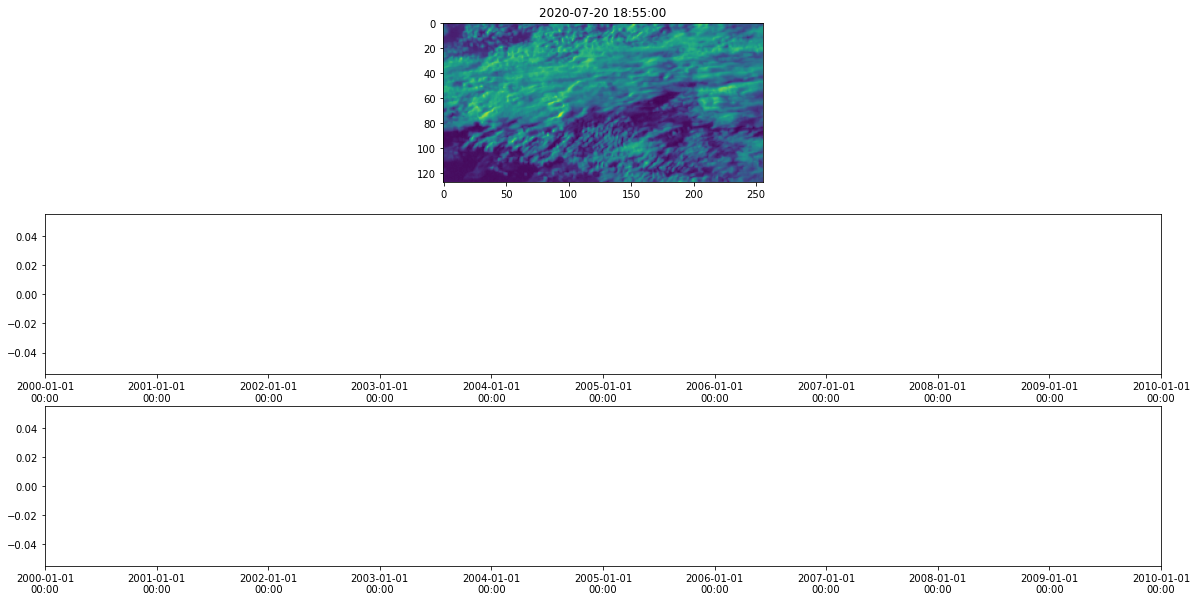

In [133]:
from power_perceiver.consts import BatchKey
import pandas as pd
import matplotlib.dates as mdates


EXAMPLE_IDX = 6
TIME_IDX = 4
CHANNEL_IDX = 0


fig, axes = plt.subplots(nrows=3, figsize=(20, 10))

ax = axes[0]
ax.set_title(pd.to_datetime(np_batch[BatchKey.hrvsatellite_time_utc][EXAMPLE_IDX, TIME_IDX], unit="s"))
ax.imshow(np_batch[BatchKey.hrvsatellite][EXAMPLE_IDX, TIME_IDX, CHANNEL_IDX])

ax = axes[1]
pv_datetimes = pd.to_datetime(np_batch[BatchKey.pv_time_utc][EXAMPLE_IDX], unit="s")
ax.plot(pv_datetimes, np_batch[BatchKey.pv][EXAMPLE_IDX])

ax = axes[2]
gsp_datetimes = pd.to_datetime(np_batch[BatchKey.gsp_time_utc][EXAMPLE_IDX], unit="s")
ax.plot(gsp_datetimes, np_batch[BatchKey.gsp][EXAMPLE_IDX])

for ax in axes[1:]:
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d\n%H:%M"))

In [68]:
np_batch[BatchKey.hrvsatellite_y_osgb][EXAMPLE_IDX].shape

torch.Size([128, 256])

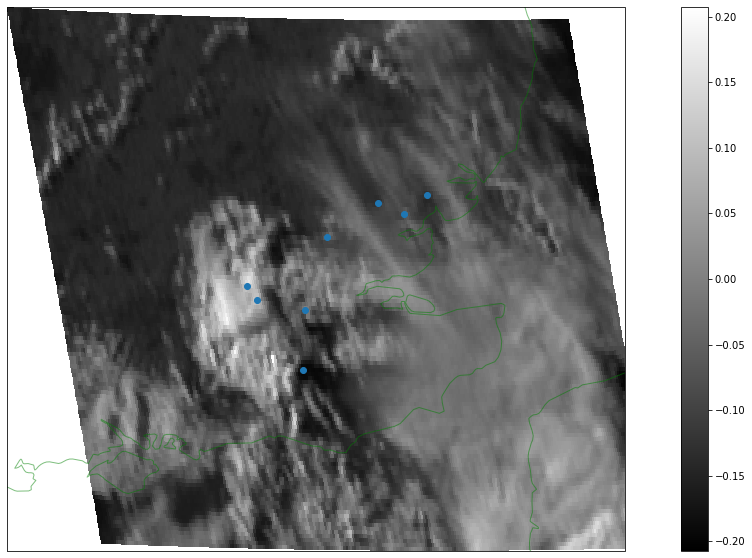

In [136]:
import xarray as xr
import cartopy.crs as ccrs

EXAMPLE_IDX = 8
TIME_IDX = 0
CHANNEL_IDX = 0

plt.rcParams['figure.figsize'] = [20, 10]

projection = ccrs.OSGB(approx=False)
ax = plt.axes(projection=projection)
DIMS = ("y", "x")
xr.DataArray(
    np_batch[BatchKey.hrvsatellite][EXAMPLE_IDX, TIME_IDX, CHANNEL_IDX],
    dims=DIMS,
    coords=dict(
        y_osgb=(DIMS, np_batch[BatchKey.hrvsatellite_y_osgb][EXAMPLE_IDX]),
        x_osgb=(DIMS, np_batch[BatchKey.hrvsatellite_x_osgb][EXAMPLE_IDX]),
    ),
).plot.pcolormesh(
    ax=ax,
    y="y_osgb",
    x="x_osgb",
    cmap="gray"
    )

ax.coastlines(alpha=0.5, color="green")

# Plot location of PV systems

ax.scatter(
    x=np_batch[BatchKey.pv_x_osgb][EXAMPLE_IDX],
    y=np_batch[BatchKey.pv_y_osgb][EXAMPLE_IDX],
)

tensor([484228.8125, 397716.2500, 413917.0625, 455351.4062, 482156.4375,
        456526.4375, 415932.6562, 445015.7812], dtype=torch.float64)